<!-- ### Libraries -->

In [ ]:
import os
from PIL import Image
import datetime
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import ast

import torch
import torchvision
import imgaug.augmenters as iaa
import timm
import torch.nn.functional as F
import torchvision.transforms.v2 as v2
from torchvision.models import convnext_base
from torchvision.transforms import functional as TF
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import Counter
import kornia.augmentation as K
from torch import nn
from efficientnet_pytorch import EfficientNet
from torchvision.transforms import transforms, Lambda
from torch.utils.data import random_split
import random
from torch.utils.data import DataLoader, WeightedRandomSampler
import glob
from torch.utils.data import Dataset
from torchvision.transforms.functional import normalize, to_pil_image

#!pip install git+https://github.com/facebookresearch/fvcore.git

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
dataset_address = '/home/shokoo/EchoView/Datasets/data_split/'
files_address = '/home/shokoo/EchoView/view_classification'
labels_name = ['plax', 'psax-ves', 'psax-sub', 'apical-2ch', 'apical-3ch', 'apical-4&5ch', 'suprasternal', 'subcostal']

In [4]:
paths = glob.glob(os.path.join(dataset_address + '**/*/*', '*')) #numebr of all samples per patients

In [5]:
avg_data_mean = np.array([0.0847569 , 0.08113708, 0.08339239])
avg_data_std = np.array([0.17340048, 0.17009241, 0.17395345])

<!-- ### Load the csv file containing the image file names and corresponding labels -->

In [6]:
info_train = pd.read_csv(os.path.join(files_address, 'csv_files/train_video_eqspaced.csv'))
info_val = pd.read_csv(os.path.join(files_address, 'csv_files/val_video_eqspaced.csv'))
info_test = pd.read_csv(os.path.join(files_address, 'csv_files/test_video_eqspaced.csv'))

In [7]:
len(info_train['label']), len(info_val['label']), len(info_test['label']), 

(4365, 1055, 1426)

In [8]:
def visualize_normalized(image, label, mean=avg_data_mean, std=avg_data_std, show=True):
    # Un-normalize
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    image = image * std + mean  # reverse normalization

    # Convert to [0, 1] and clamp to avoid display issues
    image = torch.clamp(image, 0, 1)

    # Convert to HWC
    image_np = image.permute(1, 2, 0).cpu().numpy()
    
    if show:
        # Plot
        plt.figure(figsize=(8, 6))
        plt.imshow(image_np)
        plt.title(f"Label: {label.item()}")
        plt.axis('off')
        plt.show()

    return image_np


In [9]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        def forward_hook(module, input, output):
            self.activations = output

        self.hook_handles.append(target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(target_layer.register_full_backward_hook(backward_hook))

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    def generate(self, input_tensor, class_idx=None, device='cuda'):
        self.model.zero_grad()
        input_tensor = input_tensor.to(device)

        self.model.train()
        output, _  = self.model(input_tensor, True)  # shape: [1, num_classes]
        # if class_idx is None:
        predicted = output.argmax(dim=1).item()
        class_idx = model.view_id_to_group_idx[int(class_idx)]
        target = output[0, class_idx]
        target.backward()

        self.model.eval()
        
        gradients = self.gradients.detach()
        activations = self.activations.detach()
        weights = gradients.mean(dim=(2, 3), keepdim=True)  # global average pooling

        cam = (weights * activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=input_tensor.shape[-2:], mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() + 1e-6)
        return cam, class_idx, predicted

def denormalize(tensor, mean=avg_data_mean, std=avg_data_std):
    """
    Undo normalization so images can be visualized properly.
    Input: tensor [C, H, W]
    Output: tensor [C, H, W] in 0–1 range
    """
    mean = torch.tensor(mean).view(-1, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(-1, 1, 1).to(tensor.device)
    return tensor * std + mean

def plot_interpretability(model, input_tensor, class_idx=None, device='cuda', frame_idx=0):
    model.eval()

    # Grad-CAM on one frame
    gradcam = GradCAM(model, model.features[-1])  # Last block of EfficientNet features #backbone for transformer
    # gradcam = GradCAM(model, model.backbone[-1])  # Last block of EfficientNet features #backbone for transformer
    single_frame = input_tensor[:, frame_idx:frame_idx+1, :, :, :]  # shape [1, 1, C, H, W]
    B, T, C, H, W = single_frame.shape
    # input_2d = single_frame.view(B * T, C, H, W).requires_grad_()

    cam,new_class_idx, predicted = gradcam.generate(single_frame, class_idx, device= device)
    gradcam.remove_hooks()

    # Get original frame
    raw_frame = input_tensor[0, frame_idx].cpu()
    raw_frame = denormalize(raw_frame)
    img = to_pil_image(raw_frame.clamp(0, 1))

    # Temporal attention weights
    with torch.no_grad():
        _, attn_weights = model(input_tensor.to(next(model.parameters()).device), True)
        attn_weights = attn_weights.squeeze().cpu().numpy()

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    # Original Frame
    axs[0].imshow(img)
    axs[0].set_title(f"Original Frame, actual : {labels_name[new_class_idx]}, predicted: {labels_name[predicted]}")
    axs[0].axis('off')

    # Grad-CAM
    axs[1].imshow(img, alpha=0.6)
    axs[1].imshow(cam, cmap='jet', alpha=0.4)
    axs[1].set_title("Spatial Attention (Grad-CAM)")
    axs[1].axis('off')

    # Temporal Attention
    axs[2].bar(range(len(attn_weights)), attn_weights)
    axs[2].set_title("Temporal Attention Over Frames")
    axs[2].set_xlabel("Frame Index")
    axs[2].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

<!-- ##### Define Transformers -->

In [10]:
class AddGaussianNoise(nn.Module):
    """Add Gaussian noise to a video."""
    def __init__(self, mean=0., std=0.1):
        super().__init__()
        self.mean = mean
        self.std = std

    def forward(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
class MotionBlurWrapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.blur = K.RandomMotionBlur(kernel_size=5, angle=[-10., 10.], direction=[-0.5, 0.5], p=1.0)

    def forward(self, x):
        return self.blur(x.unsqueeze(0)).squeeze(0)
    
class RandomErasingWrapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.coarse_dropout = K.RandomErasing(scale=(0.015, 0.04), ratio=(0.2, 3.3), p=0.2)

    def forward(self, x):
        return self.coarse_dropout(x.unsqueeze(0)).squeeze(0)

class QualityDecay(nn.Module):
    def __init__(self, strength=0.5, mode="noise_blur"):
        super().__init__()
        self.strength = strength
        self._deterministic = False
        self.mode = mode

    def set_deterministic(self):
        self._deterministic = True

    def forward(self, x):
        C, H, W = x.shape
        device = x.device

        # Create vertical + radial mask (0 at top/edge, 1 at bottom/center)
        y = torch.linspace(0, 1, H, device=device).unsqueeze(1).repeat(1, W)  # vertical gradient
        x_pos = torch.linspace(-1, 1, W, device=device).unsqueeze(0).repeat(H, 1)  # horizontal wedge
        r = torch.sqrt(x_pos**2 + (y - 0.5)**2)
        decay_mask = ((0.3 * y + 0.7 * r) ).clamp(0, 1)

        decay_mask = decay_mask.unsqueeze(0).repeat(C, 1, 1)  # [C, H, W]

        if self.mode == "noise_blur":
            if self._deterministic:
                self._noise = torch.randn_like(x) * self.strength
                noise = self._noise * decay_mask
            else:
                noise = torch.randn_like(x) * decay_mask * self.strength
            x = x + noise
            # Apply slight blur by average pooling, weighted by mask
            blurred = F.avg_pool2d(x.unsqueeze(0), 3, stride=1, padding=1).squeeze(0)
            x = (1 - decay_mask) * x + decay_mask * blurred

        elif self.mode == "contrast_drop":
            mean = x.mean(dim=(1, 2), keepdim=True)
            x = (1 - decay_mask) * x + decay_mask * mean  # pull toward mean (less contrast)

        return x
    
class RandomSectorCrop(nn.Module):
    def __init__(self, width_range=(0.5, 1.0), fill=0):
        super().__init__()
        self.width_range = width_range
        self.fill = fill
        self._diterministic = None
    
    def set_deterministic(self, img_shape=None):
        if img_shape is not None:
            _, W, _ = img_shape
        else:
            W = 224  # fallback, needs a proper size
        scale_w = torch.empty(1).uniform_(*self.width_range).item()
        new_W = int(W * scale_w)
        self._diterministic = new_W
    
    def forward(self, img):
        _, W, H = img.shape
        # scale_w = torch.empty(1).uniform_(*self.width_range).item()
        # new_W = int(W * scale_w)

        new_W = self._diterministic

        center = W//2
        left = max(center - new_W//2, 0)
        right = left + new_W
 
        cropped = img[:, :, left:right]

        pad_left = (W - new_W) // 2
        pad_right = W - new_W - pad_left
        
        padded = TF.pad(cropped, [pad_left, 0, pad_right, 0], fill=self.fill)

        return padded

class ImgAugWrapper:
    def __init__(self, augmenter):
        self.augmenter = augmenter
        self.det_augmenter = None

    def set_deterministic(self):
        self.det_augmenter = self.augmenter.to_deterministic()

    def __call__(self, frames: torch.Tensor) -> torch.Tensor:
        is_single = frames.dim() == 3
        if is_single:
            frames = frames.unsqueeze(0)  # [1, C, H, W]

        frames_np = (frames.permute(0, 2, 3, 1).cpu().numpy() * 255).astype(np.uint8)
        
        augmented_np = self.det_augmenter(images=frames_np)
        augmented = torch.from_numpy(augmented_np).float() / 255.0
        augmented = augmented.permute(0, 3, 1, 2)

        if is_single:
            return augmented[0]
        return augmented

    @property
    def name(self):
        return self.augmenter.name if hasattr(self.augmenter, 'name') else str(self.augmenter)

    def __repr__(self):
        return f"ImgAugWrapper({self.name})"

In [11]:
class VideoAugmentation(nn.Module):
    def __init__(self, augmentations, num_select=2, seed=None):
        super().__init__()
        self.augmentations = augmentations
        self.num_select = num_select
        self.seed = seed

    def forward(self, video_tensor: torch.Tensor):

        first_frame_shape = video_tensor[0].shape

        for aug in self.augmentations:
            if isinstance(aug, ImgAugWrapper):
                aug.set_deterministic()
            elif hasattr(aug, "set_deterministic"):
                if "img_shape" in aug.set_deterministic.__code__.co_varnames:
                    aug.set_deterministic(img_shape=first_frame_shape) #pass image shape as argument
                else:
                    aug.set_deterministic()

        selected = random.sample(self.augmentations, k=self.num_select)

        for aug in selected:
            video_tensor = torch.stack([aug(frame) for frame in video_tensor])

        return video_tensor

In [12]:
original_size = (224, 224) 

video_augs = [
    QualityDecay(strength=0.3, mode='contrast_drop'),
    RandomSectorCrop(width_range=(0.45, 0.8)),
    ImgAugWrapper(iaa.KeepSizeByResize(iaa.Crop(percent=(0.2, 0.2, 0.2, 0.2)))),
    ImgAugWrapper(iaa.Fliplr(0.5)), #horizontally
    ImgAugWrapper(iaa.Flipud(0.5)), #vetrically
    ImgAugWrapper(iaa.GammaContrast((0.8, 1.2))),
    ImgAugWrapper(iaa.SigmoidContrast(gain=(5, 10))),
    ImgAugWrapper(iaa.LogContrast(gain=(0.8, 1.2))),
    ImgAugWrapper(iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255))),
    ImgAugWrapper(iaa.GaussianBlur(sigma=(0, 1.5))),
    # ImgAugWrapper(iaa.CoarseDropout((0.02, 0.1), size_percent=(0.05, 0.05), per_channel=False)),
    ImgAugWrapper(iaa.Affine(scale=(0.9, 1.1), translate_percent=(-0.05, 0.05), rotate=(-15, 15), shear=(-8, 8), mode='constant', cval=0)),
    ImgAugWrapper(iaa.PerspectiveTransform(scale=(0.01, 0.05), mode='constant', cval=0)),
]
video_aug_pipeline = VideoAugmentation(video_augs, num_select=4)

aug_name_list = []
for aug in video_augs:
    if isinstance(aug, ImgAugWrapper):
        aug_name_list.append(aug.name.split('Unnamed')[-1])
    else:
        aug_name_list.append(aug.__class__.__name__)

In [13]:
def pick_frame_strategy(length):
    strategies = []

    # Always feasible
    strategies.append("equally_spaced")          # 10 frames equally spaced
    strategies.append("middle_consecutive")      # 10 middle consecutive
    strategies.append("first_consecutive")       # 10 first consecutive

    # Conditional options
    if length >= 50:
        strategies.append("spaced_step_5")       # step=5 → covers 10*5 = 50
    if length >= 30:
        strategies.append("spaced_step_3")       # step=3 → covers 10*3 = 30
        
    return random.choice(strategies)

<!-- ### Map images to their labels -->

In [ ]:
class TTEDataset(Dataset):
    def __init__(self, csv_info, root_dir, data_mean=0.5, data_std=0.5,
                 use_npy=True, transform=None, remove_ecg=True, remove_static=True):
        self.meta = csv_info
        self.root_dir = root_dir
        self.data_mean = data_mean
        self.data_std = data_std
        self.use_npy = use_npy
        self.transform = transform
        self.remove_ecg = remove_ecg
        self.remove_static = remove_static
        self.label_mapping = {
            'PLAX': 0, 'PSAX-ves': 1, 'PSAX-base': 2, 'PSAX-mid': 3,
            'PSAX-apical': 4, 'Apical-2ch': 5, 'Apical-3ch': 6,
            'Apical-5ch': 7, 'Apical-4ch': 8, 'Suprasternal': 9, 'Subcostal': 10
        }
        self.debug_indices = set()

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        path = row['path']
        case_path = os.path.basename(path)
        frame_ids = list()
        start = row['start']
        end = row['end']
        length = end - start  + 1
        label = torch.tensor(self.label_mapping[row['label']], dtype=torch.long)
        num_frames = 10 # number of frames per video

        # frame_strategy = pick_frame_strategy(length)

        # if idx in self.debug_indices:
        #     print(f"[Debug] Frame strategy for idx {idx}: {frame_strategy}")

        # match frame_strategy:
        #     case "equally_spaced":
        #         step = length / num_frames
        #         frame_ids = [int(i * step) for i in range(num_frames)]
        #     case "middle_consecutive":
        #         middle = (length - num_frames) // 2
        #         frame_ids = list(range(middle, middle + num_frames))
        #     case "first_consecutive":
        #         frame_ids = list(range(0, num_frames))
        #     case "spaced_step_3":
        #         step = 3
        #         required = (num_frames - 1) * step + 1
        #         if length < required:
        #             raise ValueError("Video too short for spaced step=3 sampling")
        #         frame_ids = [i * step for i in range(num_frames)]
        #     case "spaced_step_5":   
        #         step = 5
        #         required = (num_frames - 1) * step + 1
        #         if length < required:
        #             raise ValueError("Video too short for spaced step=3 sampling")
        #         frame_ids = [i * step for i in range(num_frames)]
        
        step = length/num_frames
        frame_ids = [int(i*step) for i in range(num_frames)]

        # Load images
        images = []
        for frame_id in frame_ids:
            img_path = os.path.join(self.root_dir, path, f"{case_path}_{frame_id}.png")
            image = Image.open(img_path).convert("RGB")
            images.append(np.array(image))  # Save as numpy arrays for preprocessing

        # ECG Removal
        if self.remove_ecg:
            images = self.remove_ecg_line(images)

        # Background Removal
        if self.remove_static:
            images = self.remove_static_background(images)

        # Convert to tensor: [T, C, H, W]
        frames_tensor = torch.stack([self.ensure_tensor_rgb(img) for img in images])

        # Apply optional transforms (assumed batch-safe)
        if self.transform:
            frames_tensor = video_aug_pipeline(frames_tensor)

        # Resize and normalize
        processed_frames = []
        for frame in frames_tensor:
            frame = transforms.Grayscale(num_output_channels=3)(frame)
            frame = TF.resize(frame, size=[224, 224])
            frame = TF.normalize(frame, mean=self.data_mean, std=self.data_std)
            processed_frames.append(frame)
            
        frames_tensor = torch.stack(processed_frames)


        return frames_tensor, label

    def ensure_tensor_rgb(self, image):
        if isinstance(image, np.ndarray):
            image = torch.tensor(image).float() / 255.0
            image = image.permute(2, 0, 1)  # [H, W, C] → [C, H, W]
        elif isinstance(image, Image.Image):
            image = TF.to_tensor(image)
        elif isinstance(image, torch.Tensor):
            if image.max() > 1.0:
                image = image / 255.0
        return image

    def remove_ecg_line(self, images):
        output = []
        for img in images:
            hsv = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2HSV)
            mask = cv2.inRange(hsv, (40, 40, 40), (80, 255, 255))
            img[mask > 0] = 0
            output.append(img)
        return output

    def remove_static_background(self, images):
        image_array = torch.stack([TF.to_tensor(img) for img in images])
        if image_array.max() > 1.0:
            image_array /= 255.0

        slices, ch, height, width = image_array.shape
        mask = torch.zeros((ch, height, width), dtype=torch.uint8)
        steps = min(5, slices)
        for i in range(steps - 1):
            mask |= (image_array[i] != image_array[i + 1])  # element-wise comparison
        output = image_array * mask  # static pixels become zero
        return output


<!-- ### Load the train,val,test dataset from the folder -->

In [15]:
train_data = TTEDataset(
    csv_info=info_train, root_dir=dataset_address, data_mean = avg_data_mean, data_std = avg_data_std, use_npy=False, remove_ecg=True, remove_static=True, 
    transform=True,
)

val_data = TTEDataset(
    csv_info=info_val, root_dir=dataset_address, data_mean = avg_data_mean, data_std = avg_data_std, use_npy=False, remove_ecg=True, remove_static=True,
)

test_data = TTEDataset( 
    csv_info=info_test, root_dir=dataset_address, data_mean = avg_data_mean, data_std = avg_data_std, use_npy=False, remove_ecg=True, remove_static=True 
)

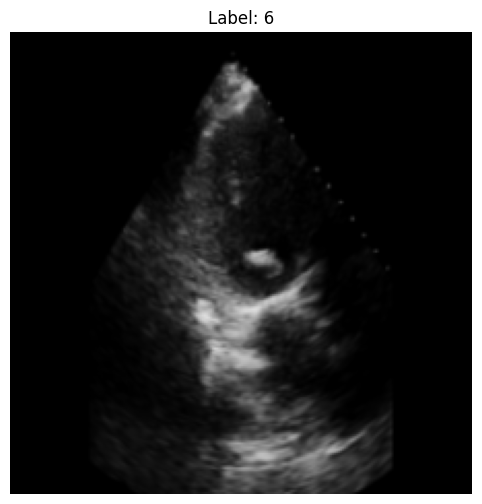

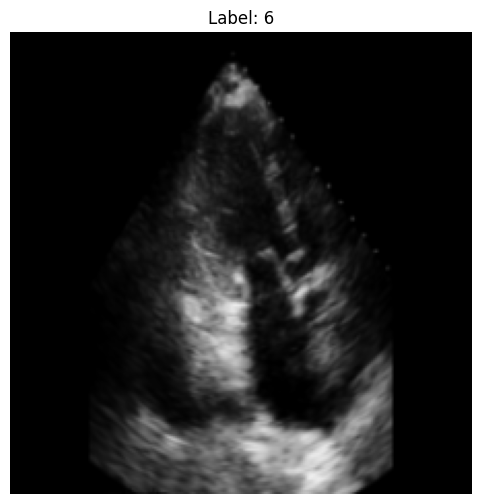

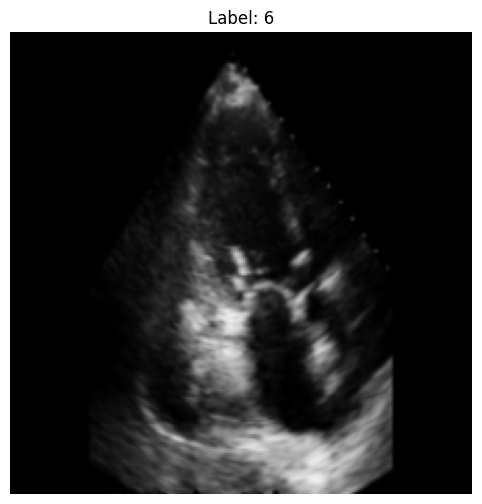

In [16]:
num = random.randint(0,1100)
img, label = train_data[num]
for i in range(0,9,4):
    visualize_normalized(img[i,:,:], label, avg_data_mean, avg_data_std)

<!-- ### Create data loaders for the train and validation sets
 -->


### Data Sampler

In [17]:
label_counts = Counter(info_train['label'])
views = list(label_counts.keys()) # in this order ['PLAX','Suprasternal','PSAX-ves','PSAX-base','PSAX-mid','PSAX-apical','Apical-4ch','Apical-5ch','Apical-2ch','Apical-3ch','Subcostal']
frequencies = np.array([label_counts[v] for v in views]) 
# adjust based on new_labels 
mapped_labels_fq = np.zeros((8))
combined_view_map = {
    0: 0,     # PLAX
    1: 1,     # Suprasternal
    2: 2,     # PSAX-ves
    3: 3,     # PSAX-base
    4: 3,     # PSAX-mid
    5: 3,     # PSAX-apical
    6: 4,     # Apical-4ch
    7: 4,     # Apical-5ch
    8: 5,     # Apical-2ch
    9: 6,     # Apical-3ch
   10: 7      # Subcostal
}
total = np.sum(frequencies)

for k,v in combined_view_map.items():
    mapped_labels_fq[v] += frequencies[k]

# adjusted frequency as weights
A_i = [mapped_labels_fq[combined_view_map[i]] for i,_ in enumerate(frequencies)] / total
# Normalize to sum to 1
# N_A_i = A_i / np.sum(A_i)
P_i = 1 / A_i
N_P_i = P_i / np.sum(P_i)

K_i = np.ones_like(N_P_i)
# Indices: PLAX = 0, Apical-2ch = 8, Apical-3ch = 9
K_i[1] = 0.25     # Suprasternal
K_i[0] = 1.3      # PLAX
K_i[8] = 1.3      # Apical-2ch
K_i[9] = 1.7      # Apical-3ch

W_i = N_P_i * K_i
N_W_i = W_i / np.sum(W_i)

labels = info_train['label'].to_list()

label_weights = {k: v for k, v in zip(views, N_P_i)}

sample_weights = [label_weights[label] for label in labels]

In [18]:
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_data, batch_size=16, drop_last=False, shuffle=False, sampler=sampler)
#, pin_memory=True, num_workers= 8, persistent_workers=True)

val_loader = DataLoader(val_data, batch_size=16, drop_last=False, shuffle=False, )
# collate_fn=collate_fn)
# #pin_memory=True, num_workers= 8, persistent_workers=True)

test_loader = DataLoader(test_data, batch_size=16, drop_last=False, shuffle=False,)
#pin_memory=True, num_workers= 8, persistent_workers=True)


In [19]:
# for i,l in train_loader:
#     print(i.shape)
#     break

<!-- ### Define the neural network model architecture -->

In [20]:
combined_view_map = {
    0 : 'plax',          # PLAX
    1: 'psax-ves',     # PSAX-ves
    2: 'psax-sub',     # PSAX-base
    3: 'psax-sub',     # PSAX-mid
    4: 'psax-sub',     # PSAX-apical
    5: 'apical-2ch',   # Apical-2ch
    6: 'apical-3ch',   # Apical-3ch
    7: 'apical-4&5ch',   # Apical-5ch
    8: 'apical-4&5ch',   # Apical-4ch
    9: 'suprasternal',   # Suprasternal   
    10: 'subcostal'      # Subcostal
}

class Spatial_Temporal(nn.Module):
    def __init__(self, backbone_type='convnext_base', num_classes= 11, hidden_dim= 128):
        super(Spatial_Temporal, self).__init__()

        self.group_names = ['plax', 'psax-ves', 'psax-sub', 'apical-2ch', 'apical-3ch', 'apical-4&5ch', 'suprasternal', 'subcostal']
        self.view_id_to_group_idx = {
            view_id: self.group_names.index(combined_view_map[view_id])
            for view_id in range(11)
        }

        # base_model = torchvision.models.efficientnet_b2(weights='DEFAULT')
        # self.features = base_model.features
        # feature_channels = 1408

        base_model = torchvision.models.resnet18(weights='DEFAULT')
        self.features = nn.Sequential(*list(base_model.children())[:-2])
        feature_channels = 512

        # base_model = getattr(torchvision.models, backbone_type)(weights='IMAGENET1K_V1')
        # self.features = base_model.features
        # feature_channels = 768

            
        self.dropout2d = nn.Dropout2d(p=0.2)
        self.spatial_pool = nn.AdaptiveAvgPool2d((4,4))
        self.flatten = nn.Flatten(start_dim=2) # flatten H and W

        self.rnn = nn.GRU( feature_channels * 4 * 4, hidden_dim, batch_first=True, bidirectional=True )

        self.tempora_name = self.rnn.__class__.__name__

        self.temporal_attention = nn.Sequential( 
            nn.Linear(hidden_dim * 2, hidden_dim//2 ),
            nn.Tanh(),
            nn.Linear(hidden_dim//2, 1)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(hidden_dim * 2, num_classes)
        )

    def forward(self, x, att=False):
        B, T, C, H, W = x.size()
        x = x.view(B * T, C, H, W)
        x = self.features(x) # [B*T, C, H', W']
        x = self.spatial_pool(x) # [B*T, C, 4, 4]
        x = self.dropout2d(x)
        x = self.flatten(x).view(B, T, -1) # [B, T, C*H*W]

        rnn_out, _ = self.rnn(x) # [B, T, 2*hidden]
        attn_weights = torch.softmax(self.temporal_attention(rnn_out), dim = 1) # [B, T, 1]
        x = torch.sum(rnn_out * attn_weights, dim = 1) # [B, hidden]
        
        x = self.classifier(x)
        if att:
            return x, attn_weights
        return x
    
backbone_type = 'resnet18'
temporal_type = 'GRU'
num_classes = 8
model = Spatial_Temporal(backbone_type=backbone_type, num_classes=num_classes) #Convnext_FC (model name without CBAM)

In [20]:
model_parameters = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {model_parameters:,}")
param_size_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
param_size_mb = param_size_bytes / (1024 ** 2)
print(f"Model size (parameters): {param_size_mb:.2f} MB")
buffer_size_bytes = sum(b.numel() * b.element_size() for b in model.buffers())
total_size_mb = (param_size_bytes + buffer_size_bytes) / (1024 ** 2)
print(f"Total model size (parameters + buffers): {total_size_mb:.2f} MB")

Total parameters: 17,586,377
Model size (parameters): 67.09 MB
Total model size (parameters + buffers): 67.12 MB


In [21]:
# input1 = torch.rand(32, 10, 3, 224, 224)
# print(model(input1, True))

<!-- ### Freeze initial layers of the model -->

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cuda:0')
model.to(device)
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)


# model.lstm.flatten_parameters() 
criterion_nomral = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
# criterion = PenalizedCrossEntropyLoss(num_classes=8, penalty_map=penalty_map)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# , weight_decay=1e-5) ## changed from 0.001 to 0.0001 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

def update_optimizer(model, new_lr):
    return torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=new_lr, weight_decay=1e-5)

print(device)

cuda


In [22]:
def confusion_matrix_plt(true_labels, pred_labels, count_cm = True):
    # labels_name = valid_labels.keys()
    cm = confusion_matrix(true_labels, pred_labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    if count_cm:        
        plt.figure(figsize=(10,7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

    plt.figure(figsize=(10,7))
    sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

<!-- ### Train the model -->

In [24]:
def evaluate(model, loader, device, epoch, mode='validation'):
  model.eval()
  running_loss = 0.
  running_corrects_view = 0
  running_corrects_group = 0
  predicted_labels = []
  true_labels = []

  # BATCH_SIZE = 64
  total = 0
  for i, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze()
    with torch.no_grad():
      view_logits, _ = model(images, True)
      new_labels = torch.tensor([model.view_id_to_group_idx[v.item()] for v in labels], device=device)
      # group_targets = torch.tensor([model.view_id_to_group_idx2[v.item()] for v in new_labels], device=device)
      # group_loss = criterion_nomral(group_logits, group_targets)
      view_loss = criterion_nomral(view_logits, new_labels)
      loss = view_loss
      total += images.size(0)
      _, predictions_view = view_logits.max(1)
    # _, predictions_group = group_logits.max(1)
    running_loss += loss.item() * images.size(0)
    running_corrects_view += (predictions_view == new_labels).sum()
    # running_corrects_group += (predictions_group == group_targets).sum()
    predicted_labels.extend(predictions_view.cpu().numpy())
    true_labels.extend(new_labels.cpu().numpy())

  epoch_loss = running_loss / total
  if epoch > 2:
    confusion_matrix_plt(true_labels, predicted_labels, False)
  # if epoch % 3 ==0:
  #   for _ in range(5):
  #     index = random.randint(0,len(val_data))
  #     print('for video sample of index ', index)
  #     sample_video, sample_label = val_data[index]  # or random.choice()
  #     input_tensor = sample_video.unsqueeze(0).to(device)  # [1, T, C, H, W]
  #     plot_interpretability(model, input_tensor, class_idx=sample_label, frame_idx=5, device=device)

  # epoch_acc_group = running_corrects_group / total
  epoch_acc_view = running_corrects_view / total
  print(f'{mode} epoch {epoch}:  Loss({epoch_loss:6.4f}, Accuracy View ({epoch_acc_view:6.5f}) )')
  # print(f'{mode} epoch {epoch}:  Loss({epoch_loss:6.4f}, Accuracy Group ({epoch_acc_group:6.5f}), Accuracy View ({epoch_acc_view:6.5f}) )')
  return epoch_acc_view, epoch_loss


Train epoch 0: Loss(1.5278, Accuracy View (0.49324) )
valid epoch 0:  Loss(1.1145, Accuracy View (0.70047) )
Validation improved at epoch 0, loss: 1.1145
---
Train epoch 1: Loss(1.0713, Accuracy View (0.72646) )
valid epoch 1:  Loss(0.9528, Accuracy View (0.76967) )
Validation improved at epoch 1, loss: 0.9528
---
Train epoch 2: Loss(0.9191, Accuracy View (0.79771) )
valid epoch 2:  Loss(0.8935, Accuracy View (0.81422) )
Validation improved at epoch 2, loss: 0.8935
---
Train epoch 3: Loss(0.8582, Accuracy View (0.83574) )


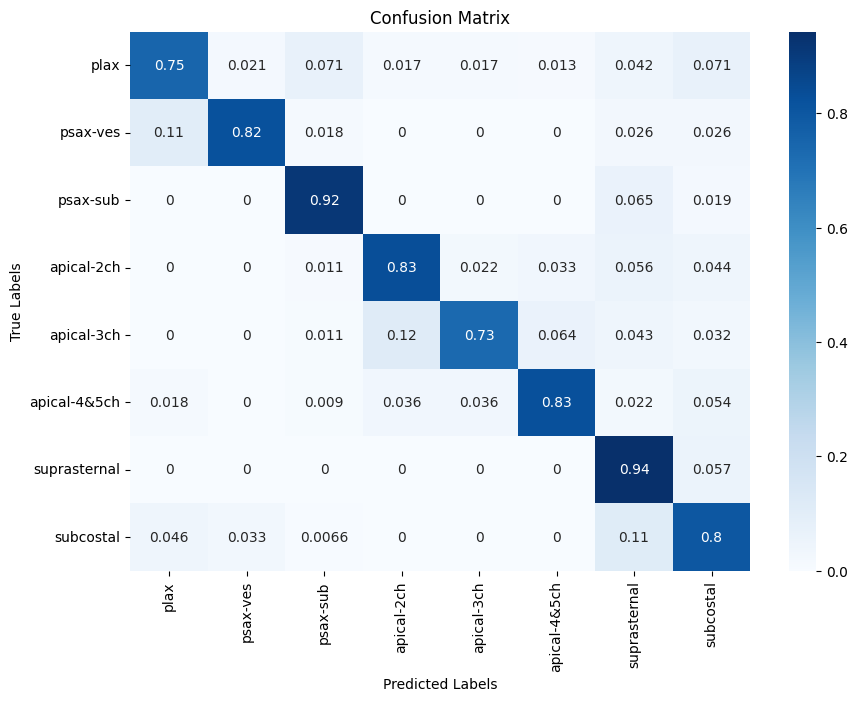

valid epoch 3:  Loss(0.9099, Accuracy View (0.81043) )
No improvement at epoch 3, patience: 1/4
---
Train epoch 4: Loss(0.8047, Accuracy View (0.86002) )


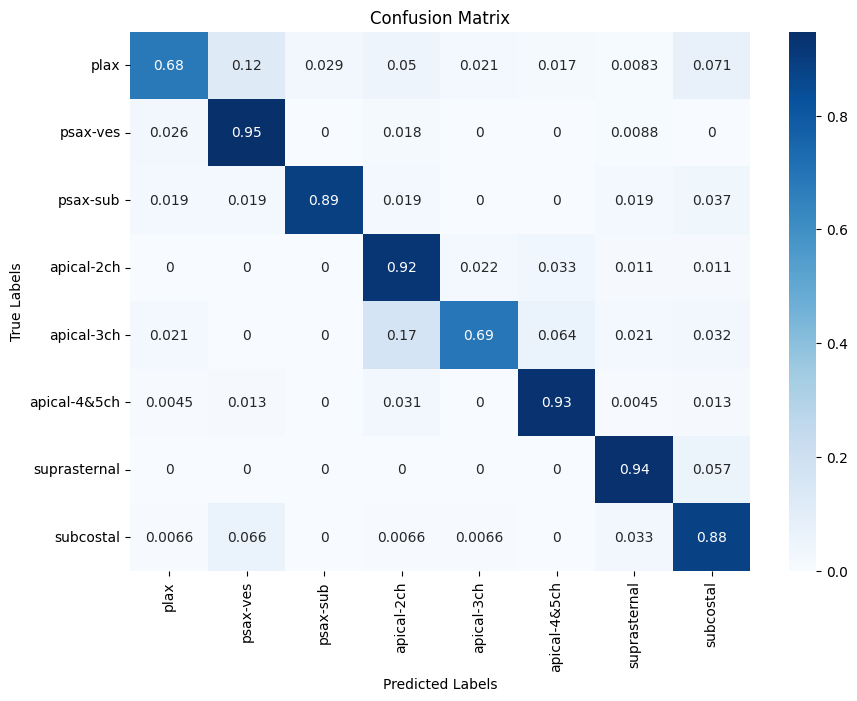

valid epoch 4:  Loss(0.8296, Accuracy View (0.84360) )
Validation improved at epoch 4, loss: 0.8296
---
Train epoch 5: Loss(0.7655, Accuracy View (0.88202) )


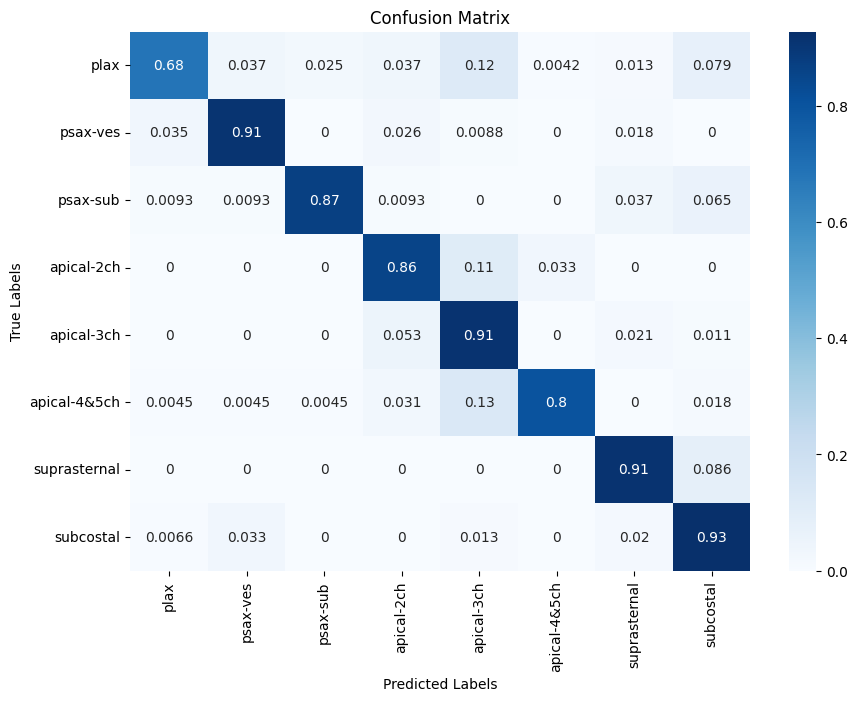

valid epoch 5:  Loss(0.8599, Accuracy View (0.83033) )
No improvement at epoch 5, patience: 1/4
---
Train epoch 6: Loss(0.7815, Accuracy View (0.86758) )


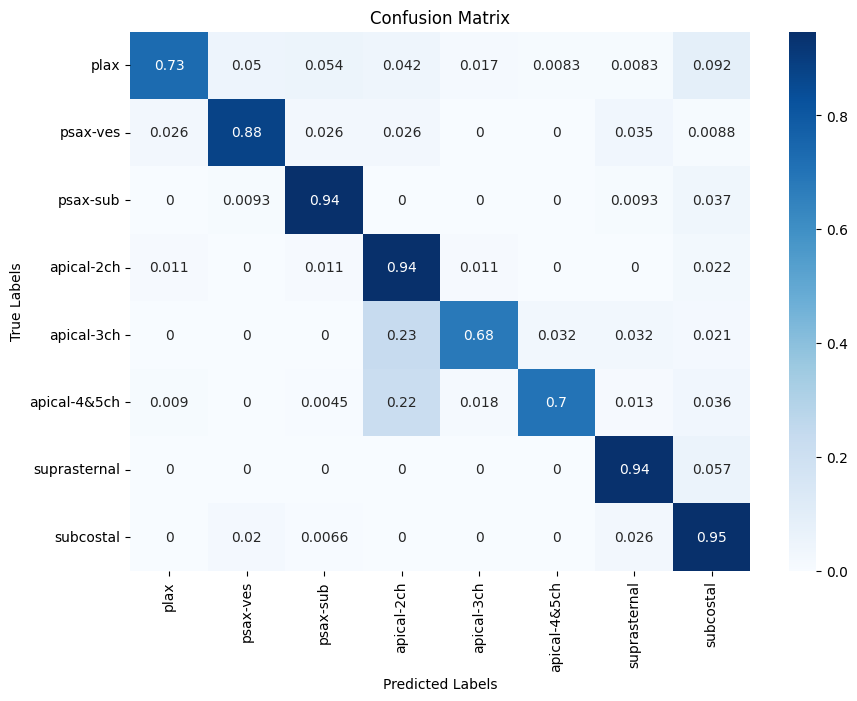

valid epoch 6:  Loss(0.8970, Accuracy View (0.81327) )
No improvement at epoch 6, patience: 2/4
---
Train epoch 7: Loss(0.7467, Accuracy View (0.88018) )


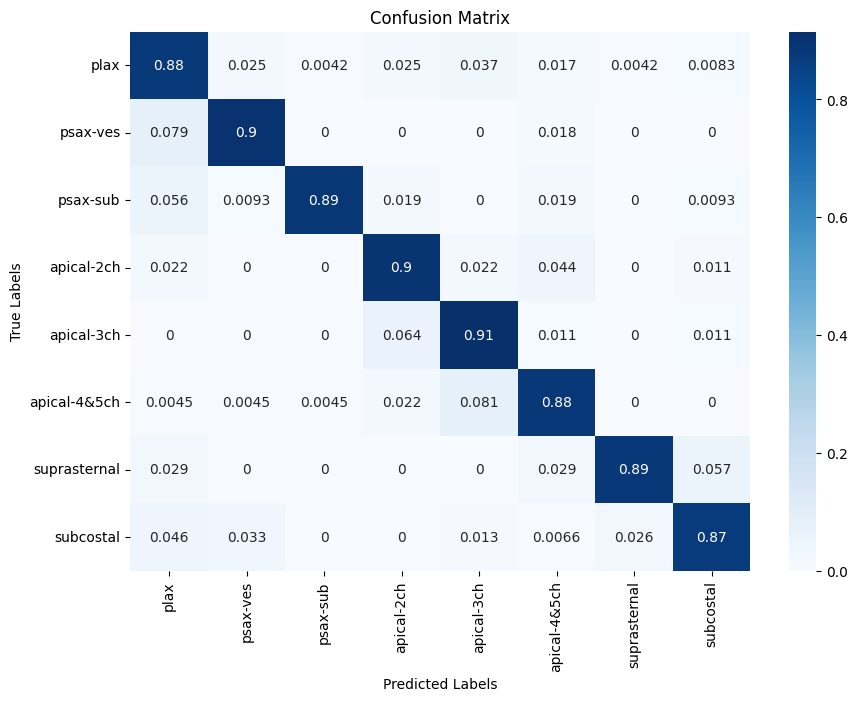

valid epoch 7:  Loss(0.7351, Accuracy View (0.88815) )
Validation improved at epoch 7, loss: 0.7351
---
Train epoch 8: Loss(0.7124, Accuracy View (0.90057) )


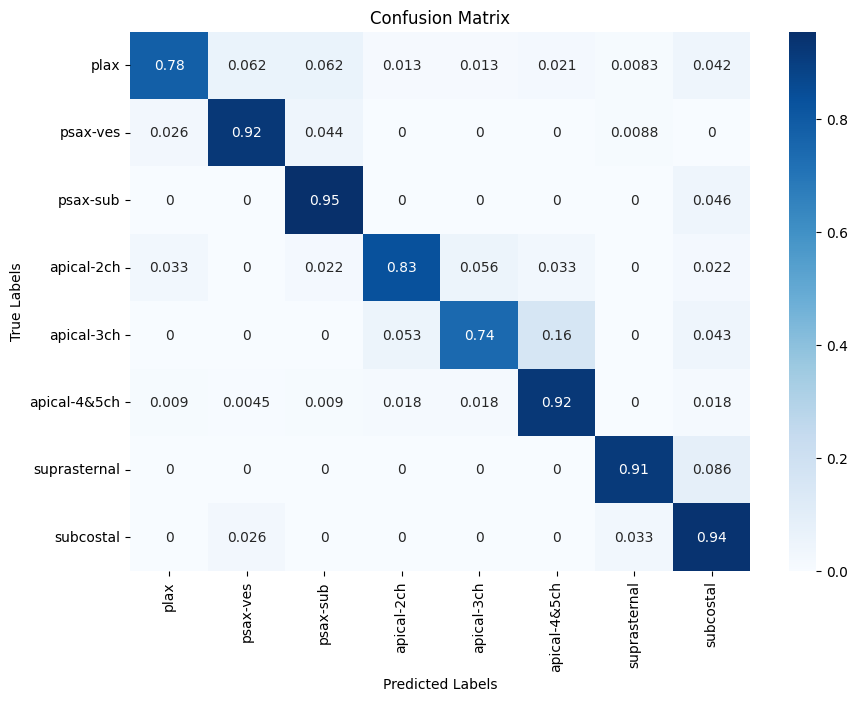

valid epoch 8:  Loss(0.7703, Accuracy View (0.87204) )
No improvement at epoch 8, patience: 1/4
---
Train epoch 9: Loss(0.7101, Accuracy View (0.90218) )


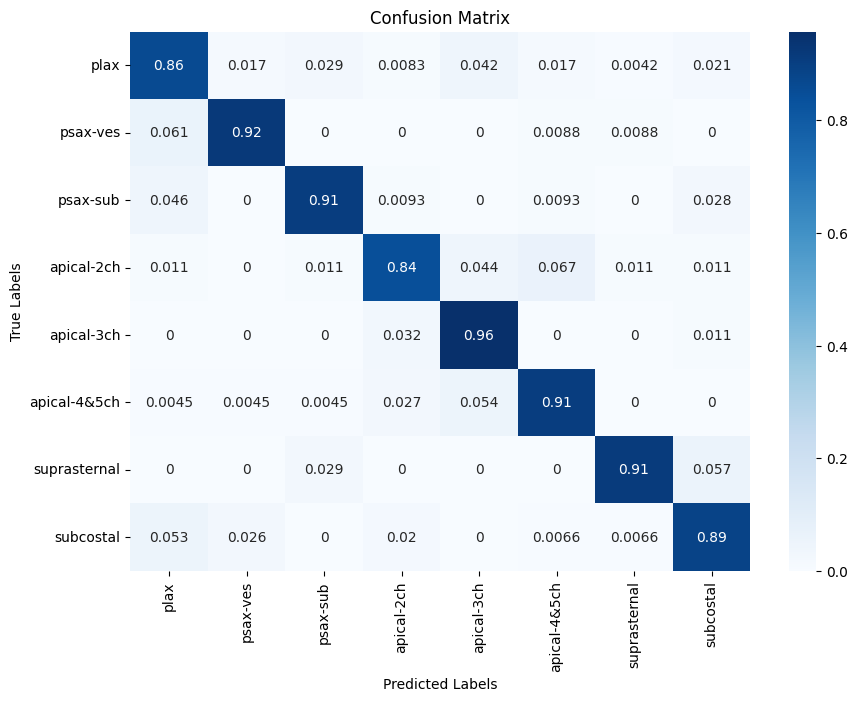

valid epoch 9:  Loss(0.7423, Accuracy View (0.89479) )
No improvement at epoch 9, patience: 2/4
---
Train epoch 10: Loss(0.6844, Accuracy View (0.91203) )


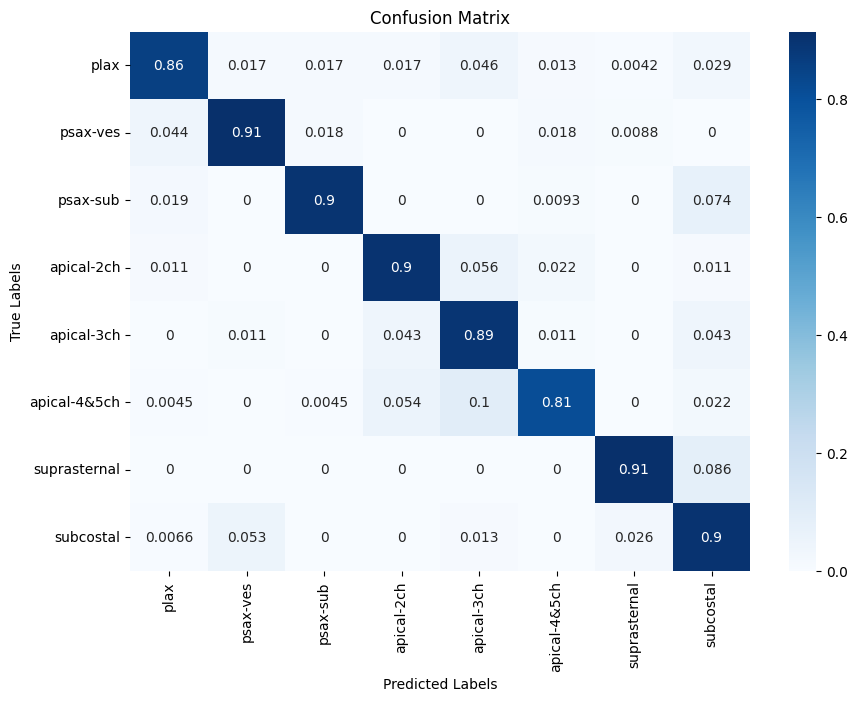

valid epoch 10:  Loss(0.7848, Accuracy View (0.87299) )
No improvement at epoch 10, patience: 3/4
---
Train epoch 11: Loss(0.6896, Accuracy View (0.91317) )


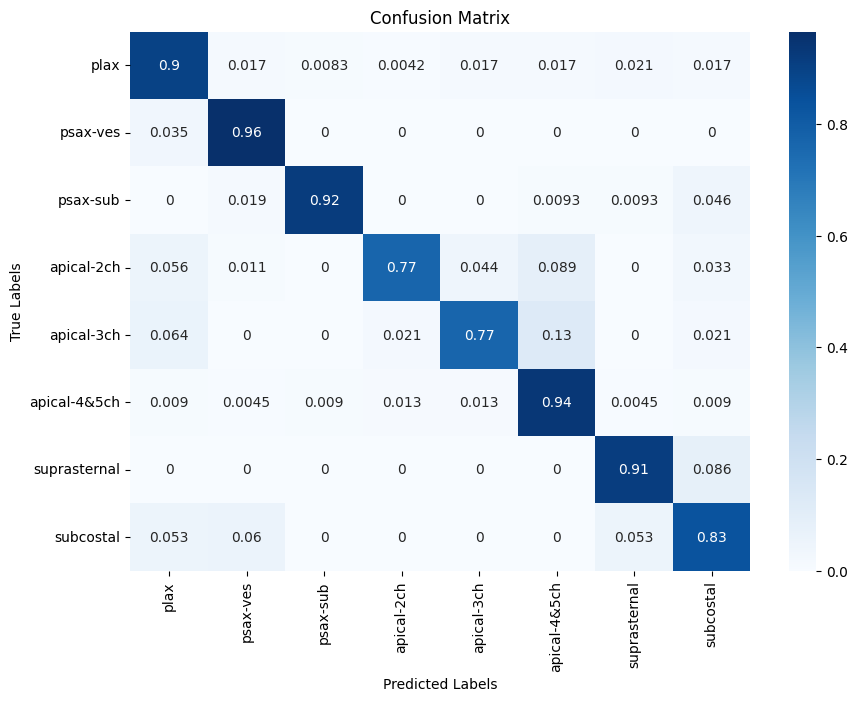

valid epoch 11:  Loss(0.7532, Accuracy View (0.88436) )
No improvement at epoch 11, patience: 4/4
---
Early stopping at epoch 11, best val_acc: 0.8882


In [25]:
epochs = 20
backbone_freeze_epoch = 3
val_loss = 0.0
best_val_loss = float('inf')
best_acc = 0
epochs_no_improve = 0
early_stop_patience = 4
min_delta = 1e-4
best_model_wts = copy.deepcopy(model.state_dict())

# freeze_backbone(model)
# print("Backbone frozen.")

for epoch in range(epochs):
  model.train()
  total = 0
  running_loss = 0.
  running_corrects_view = 0
  running_corrects_group = 0

  # if epoch == backbone_freeze_epoch:
  #   unfreeze_backbone(model)
  #   update_optimizer(model, new_lr=1e-5)
  #   print("Backbone unfrozen, optimizer updated.")

  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    view_logits = model(images)
    labels = labels.squeeze()
    new_labels = torch.tensor([model.view_id_to_group_idx[v.item()] for v in labels], device=device)
    # group_targets = torch.tensor([model.view_id_to_group_idx2[v.item()] for v in new_labels], device=device)
    # group_loss = criterion_nomral(group_logits, group_targets)
    view_loss = criterion_nomral(view_logits, new_labels)
    loss = view_loss
    loss.backward()
    optimizer.step()

    total += images.size(0)
    _, predictions_view = view_logits.max(1)
    # _, predictions_group = group_logits.max(1)
    running_loss += loss.item() * images.size(0)
    running_corrects_view += (predictions_view == new_labels).sum()
    # running_corrects_group += (predictions_group == group_targets).sum()

  epoch_loss = running_loss / total
  # epoch_acc_group = running_corrects_group / total
  epoch_acc_view = running_corrects_view / total

  print(f'Train epoch {epoch}: Loss({epoch_loss:6.4f}, Accuracy View ({epoch_acc_view:6.5f}) )')
  val_acc_view, val_loss = evaluate(model, val_loader, device, epoch, mode='valid')

  if val_loss < best_val_loss - min_delta:
      best_val_loss = val_loss
      best_acc = val_acc_view
      epochs_no_improve = 0
      best_model_wts = copy.deepcopy(model.state_dict())
      print(f"Validation improved at epoch {epoch}, loss: {val_loss:.4f}")
      print('---')
  else:
      epochs_no_improve += 1
      print(f"No improvement at epoch {epoch}, patience: {epochs_no_improve}/{early_stop_patience}")
      print('---')

  if epochs_no_improve >= early_stop_patience and epoch >= 5:
      print(f"Early stopping at epoch {epoch}, best val_acc: {best_acc:.4f}")
      break


In [98]:
torch.save({
    'model_name': 'f{model.__class__.__name__}',
    'num_classes': f'{num_classes}',
    'discription': f'video model with resampling adjusting for some views without temporal aug model ({model.__class__.__name__}) using {backbone_type} as backbone and {temporal_type} as temporal model + temporal attention with {num_classes} classes, including {[i for i in aug_name_list]} in augmentation, images shape is {img.shape}',
    'accuracyOnVal' : round(val_acc_view.item(),3),
    'date': str(datetime.datetime.now()).split('.')[0],
    'state_dict': model.state_dict(),
    'model' : model,
}, os.path.join(files_address, 'notebooks/saved_models/video', f'model_{model.__class__.__name__}-bb_({backbone_type})-tm_({temporal_type})-nclasses_{num_classes}-acc_{round(val_acc_view.item(),3)}-onlyResampling-{str(datetime.datetime.now()).split(".")[0]}.pth'))

In [35]:
model.load_state_dict(best_model_wts)
val_acc_view = best_acc

<!-- #### Load a Pretrained Model -->

In [23]:
loaded_info = torch.load(os.path.join(files_address, 'notebooks/saved_models/video', 'BEST_MODEL-model_Spatial_Temporal-bb_(resnet18)-tm_(GRU)-nclasses_8-acc_0.892-onlyResampling-2025-06-19 11:06:16.pth'))
model = loaded_info['model']
description = loaded_info['discription']
description

# # state_dict = torch.load('/home/shokoo/EchoView/video_class/singleframe/test3.pth', map_location='cpu')
# # new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
# # model.load_state_dict(new_state_dict)
# # model.to(device)
# # val_acc, val_loss = evaluate(model, val_loader, device, mode='valid')

"video model with resampling without temporal aug model (Spatial_Temporal) using resnet18 as backbone and GRU as temporal model + temporal attention with 8 classes, including ['QualityDecay', 'RandomSectorCrop', 'KeepSizeByResize', 'Fliplr', 'Flipud', 'GammaContrast', 'SigmoidContrast', 'LogContrast', 'AdditiveGaussianNoise', 'GaussianBlur', 'Affine', 'PerspectiveTransform'] in augmentation, images shape is torch.Size([10, 3, 224, 224])"

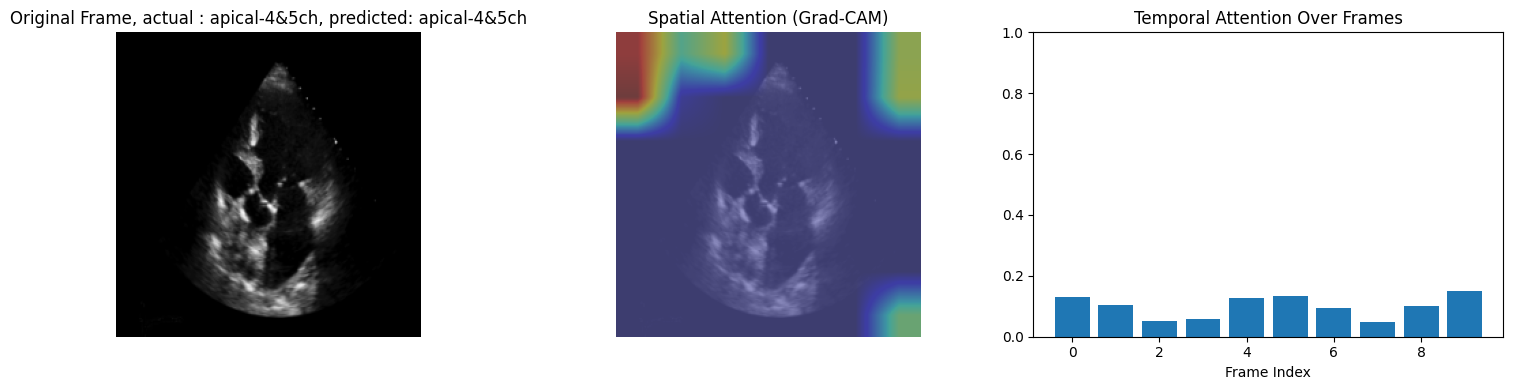

290

In [34]:
# model_name = 'model_Spatial_Temporal-bb_(resnet18)-tm_(GRU)-nclasses_8-acc_0.881-contrast_removed-2025-06-13 14:55:36.pth'
# loaded_info = torch.load(os.path.join(files_address, 'notebooks/saved_models/video', model_name))
# model = loaded_info['model']
index = random.randint(0,len(val_data))
# index = 417
val_data.debug_indices.add(index)
sample_video, sample_label = val_data[index]  # or random.choice()
val_data.debug_indices.remove(index)
input_tensor = sample_video.unsqueeze(0).to(device)  # [1, T, C, H, W]

plot_interpretability(model, input_tensor, class_idx=sample_label, frame_idx=5, device=device)
index

In [28]:
def evaluate_test(model, loader, device, mode='Test'):
  model.eval()
  total_correct = 0
  total_loss = 0
  indices = []
  predicted_labels = []
  true_labels = []
  confidences = []
  # BATCH_SIZE = 64
  total = 0
  for i, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze()
    with torch.no_grad():
      outputs = model(images)
      # loss = criterion(outputs, labels)
      # total_loss += loss.item() * images.size(0)
      batch_start = i * loader.batch_size
      batch_indices = list(range(batch_start, batch_start + images.size(0)))
      total += images.size(0) 
      _, predictions = outputs.max(1)
      new_labels = torch.tensor([model.view_id_to_group_idx[v.item()] for v in labels], device=device)
      total_correct += (new_labels == predictions).sum()
      confidence = torch.softmax(outputs, dim=1)
      confidences.extend(confidence.cpu().numpy())
      indices.extend(batch_indices)
      predicted_labels.extend(predictions.cpu().numpy())
      true_labels.extend(new_labels.cpu().numpy())

  # print(total_correct, total, accuracy)
  # loss = total_loss / total
  accuracy = total_correct / total
  # print(f'{mode} Loss({loss:6.4f}),  Accuracy ({accuracy:6.4f}))')
  print(f'{mode}  Accuracy ({accuracy:6.4f}))')
  test_dict = {'indices': indices, 'predicted': predicted_labels, 'true_labels': true_labels, 'confidence': confidences }
  return accuracy, pd.DataFrame(test_dict)

_, test_dict = evaluate_test(model, loader= test_loader, device = device)
true_labels, pred_labels = test_dict['true_labels'], test_dict['predicted']  

Test  Accuracy (0.8919))


In [29]:
test = pd.concat([test_dict, info_test], axis = 1)

def get_mode(series):
    return series.mode()[0] if not series.mode().empty else None

def get_mean(series):
    return series.mean()


res = test.groupby(['path', 'true_labels', 'label']).agg({ 'confidence': get_mean, 'predicted': get_mode, 'end': 'first', 'disease': 'first' } ).reset_index() 
# res['predicted2'] = res['confidence'].apply(lambda x : x.argmax())
res

def calculate_accuracy(true_labels, predicted_labels):
    correct = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
    print(correct)
    total = len(true_labels)
    print(total, total - correct)
    accuracy = correct / total
    return accuracy

true_labels, pred_labels = res['true_labels'], res['predicted']
calculate_accuracy(true_labels, pred_labels)

941
1055 114


0.8919431279620853

In [30]:
wrong = res[res['predicted']!=res['true_labels']]
# wrong[wrong['true_labels'] == 4]

In [31]:
wrong.to_csv('wrong_val.csv', index=False)

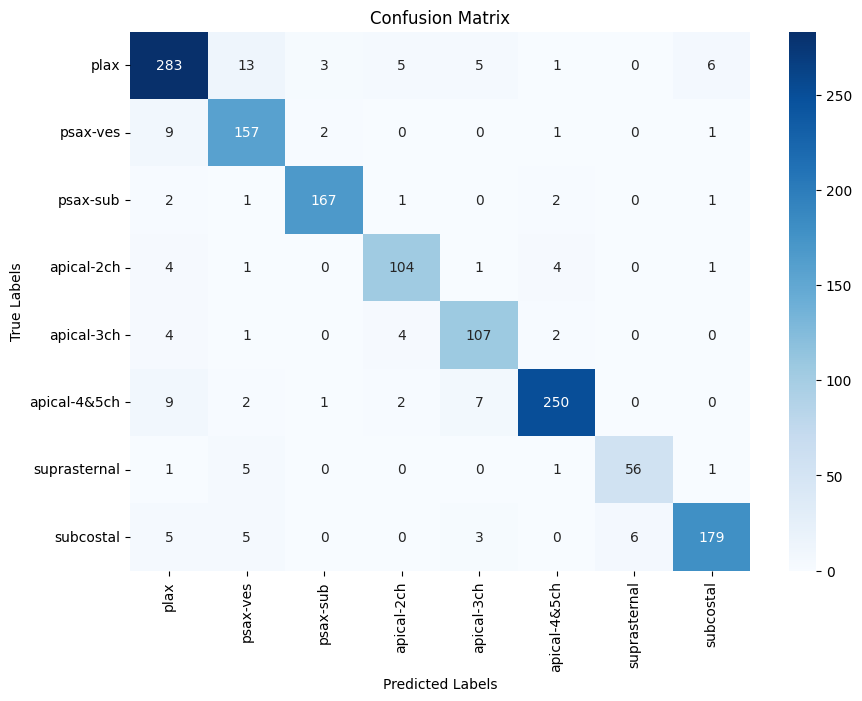

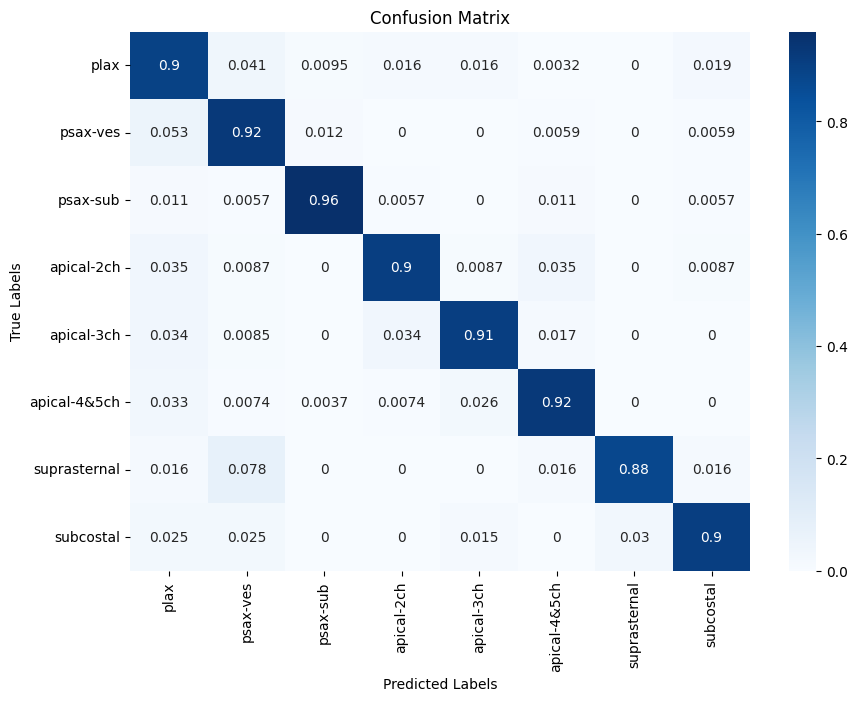

In [26]:
confusion_matrix_plt(true_labels, pred_labels)